In [1]:
import tensorflow as tf
import scipy.io
import os
import pathlib
from matplotlib import pyplot as plt

In [2]:
date = "240621" 
shot = "15"
PATH = pathlib.Path('/Users/shohgookazaki/Library/CloudStorage/GoogleDrive-shohgo-okazaki@g.ecc.u-tokyo.ac.jp/My Drive/OnoLab/data/SXR_data/' + date + '/shot' + shot)
savePATH = '/Users/shohgookazaki/Library/CloudStorage/GoogleDrive-shohgo-okazaki@g.ecc.u-tokyo.ac.jp/My Drive/OnoLab/data/result_matrix'

In [3]:
N_projection = 50
N_grid = 91

In [4]:
# The facade training set consist of 400 images
BUFFER_SIZE = 800
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

In [5]:
def get_sorted_file_list(dataset_path, pattern):
    file_list = list(dataset_path.glob(pattern))
    file_list.sort()  # ファイル名順にソート
    return file_list

def load_mat_files(input_path):
    mat_sxr = scipy.io.loadmat(input_path.numpy())
    return mat_sxr['sxr1'], mat_sxr['sxr2'],mat_sxr['sxr3'],mat_sxr['sxr4']  # 必要に応じてキーを変更してください

def load_data(input_data):
    sxr1, sxr2, sxr3, sxr4 = load_mat_files(input_data)
    
    sxr1 = tf.expand_dims(sxr1, -1)
    sxr2 = tf.expand_dims(sxr2, -1)
    sxr3 = tf.expand_dims(sxr3, -1)
    sxr4 = tf.expand_dims(sxr4, -1)
    
    sxr1 = tf.cast(sxr1, tf.float32)
    sxr2 = tf.cast(sxr2, tf.float32)
    sxr3 = tf.cast(sxr3, tf.float32)
    sxr4 = tf.cast(sxr4, tf.float32)

    return sxr1, sxr2, sxr3, sxr4


def tf_load_data(input_data):
    return tf.py_function(func=load_data, inp=[input_data], Tout=[tf.float32, tf.float32, tf.float32, tf.float32])


In [6]:
input_files = get_sorted_file_list(PATH, '*.mat')

input_dataset = tf.data.Dataset.from_tensor_slices([str(f) for f in input_files])
input_dataset = input_dataset.map(tf_load_data, num_parallel_calls=tf.data.AUTOTUNE)
input_dataset = input_dataset.batch(BATCH_SIZE)

2024-09-26 21:33:12.049095: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-26 21:33:12.049125: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-26 21:33:12.049132: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-26 21:33:12.049156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-26 21:33:12.049173: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
OUTPUT_CHANNELS = 1

In [8]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [9]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [10]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[N_projection,N_projection,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #downsample(512, 4),  # (batch_size, 2, 2, 512)
    #downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])
  
  
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Lambda(lambda inputs: tf.image.resize(inputs[0], size=(tf.shape(inputs[1])[1], tf.shape(inputs[1])[2])))([x, skip])
    x = tf.keras.layers.Concatenate()([x, skip])
  
  x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=(N_grid, N_grid)))(x)
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
generator = Generator()

In [12]:
LAMBDA = 100

In [13]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [15]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[N_grid,N_grid,1], name='input_image')
  tar = tf.keras.layers.Input(shape=[N_grid,N_grid,1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [16]:
discriminator = Discriminator()

In [17]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:

def generate_images(model, index, sxr1, sxr2, sxr3, sxr4):
  EE1 = model(sxr1, training=True)
  EE2 = model(sxr2, training=True)
  EE3 = model(sxr3, training=True) 
  EE4 = model(sxr4, training=True)
  plt.figure(figsize=(15, 15))
  
  # Create a dictionary to hold the data
  display_list = [sxr1[0], EE1[0], sxr2[0], EE2[0], sxr3[0], EE3[0], sxr4[0], EE4[0]]
  title = [f'{index}Input 1', 'Predicted 1', 'Input 2', 'Predicted 2', 'Input 3', 'Predicted 3', 'Input 4', 'Predicted 4']

  for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i]*0.5+0.5)
    plt.axis('off')
  plt.show()
  
  

In [21]:
!ls {checkpoint_dir}

checkpoint                 ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001 ckpt-5.index
ckpt-1.index               ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001 ckpt-6.index
ckpt-2.index               ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001 ckpt-7.index
ckpt-3.index               ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001 ckpt-8.index
ckpt-4.index


In [22]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

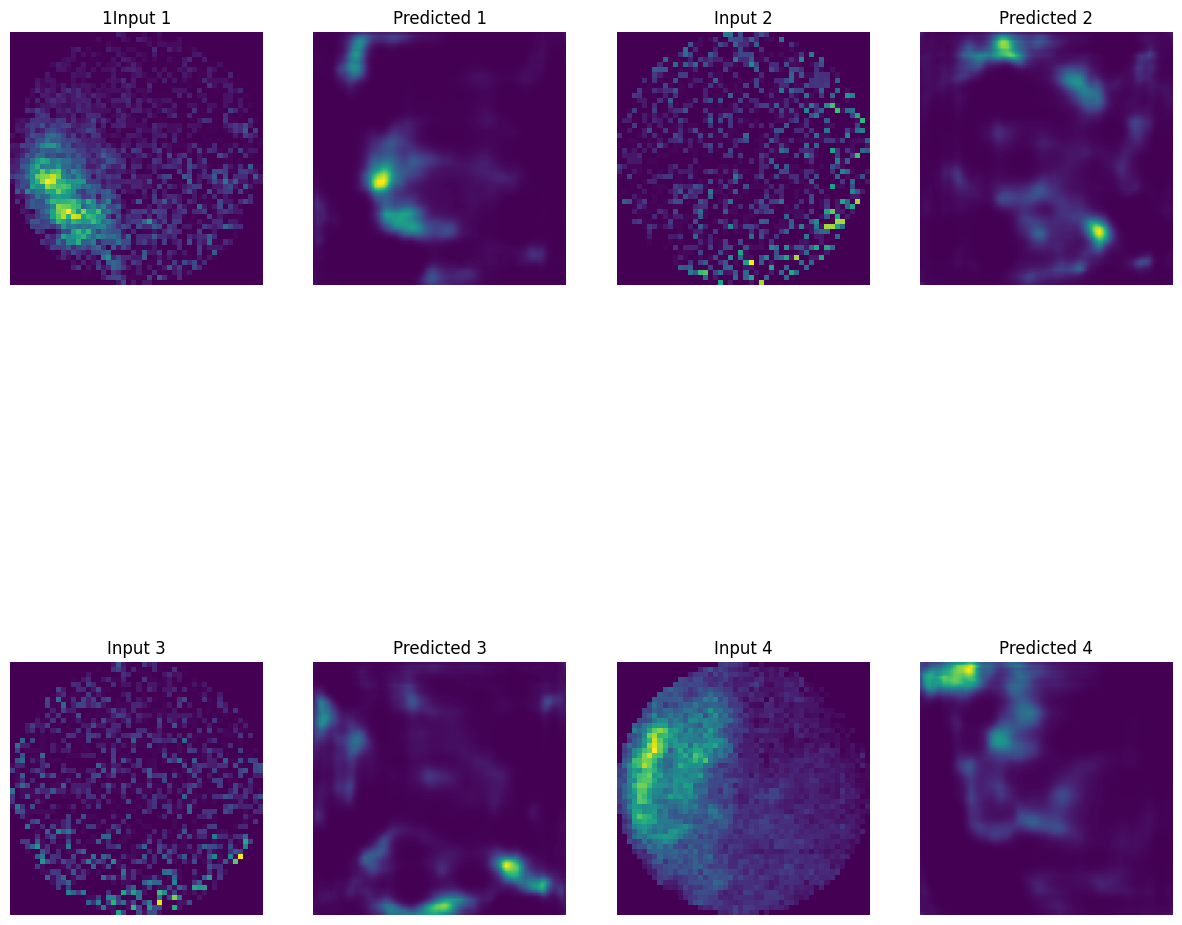

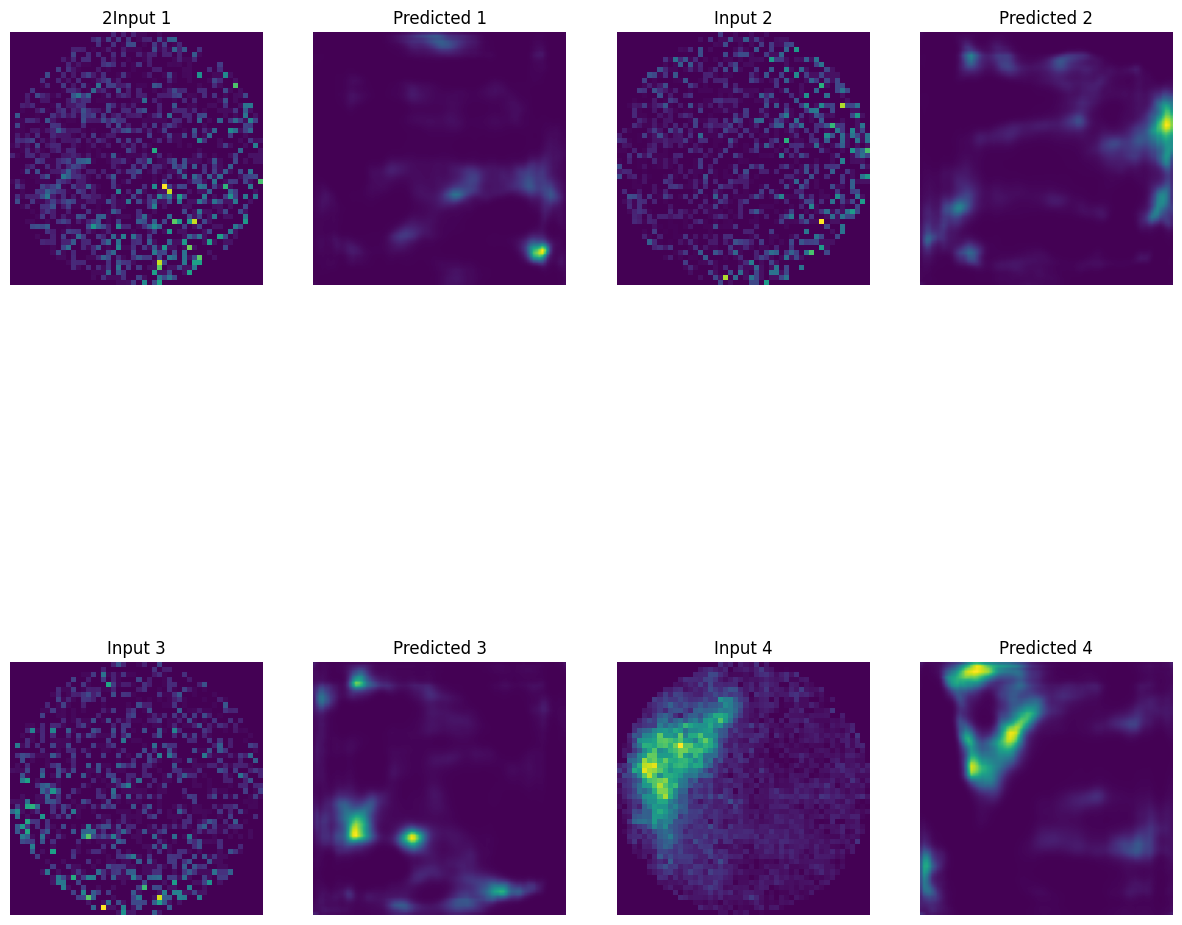

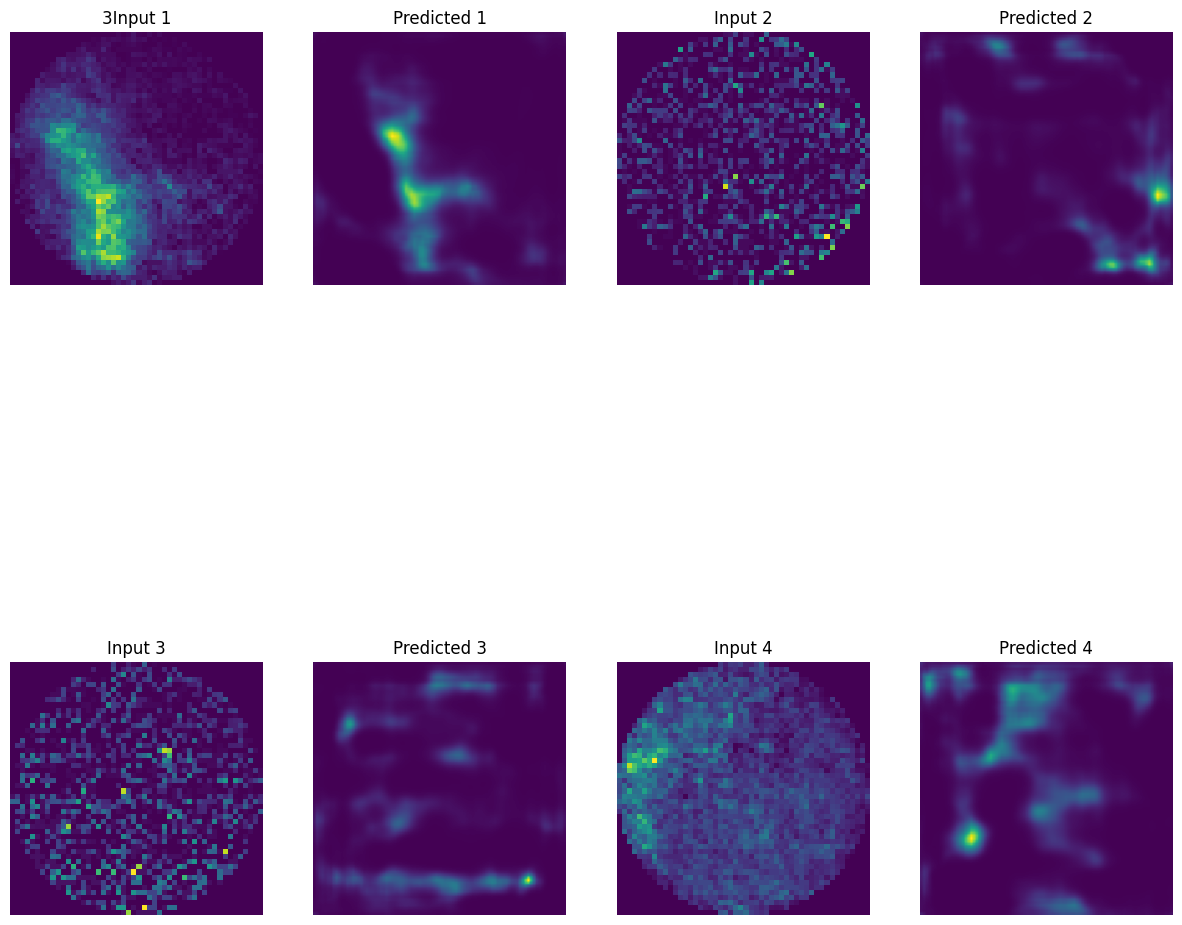

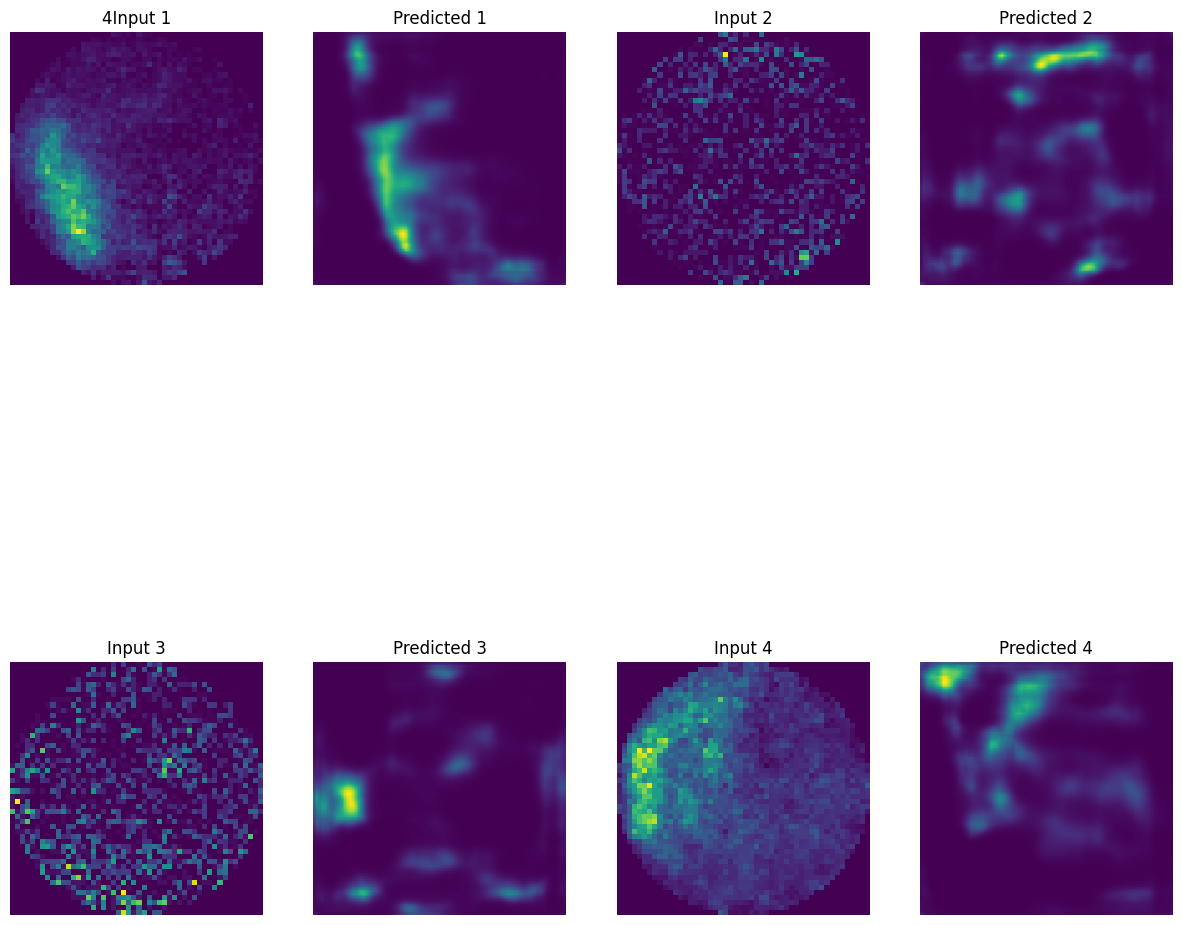

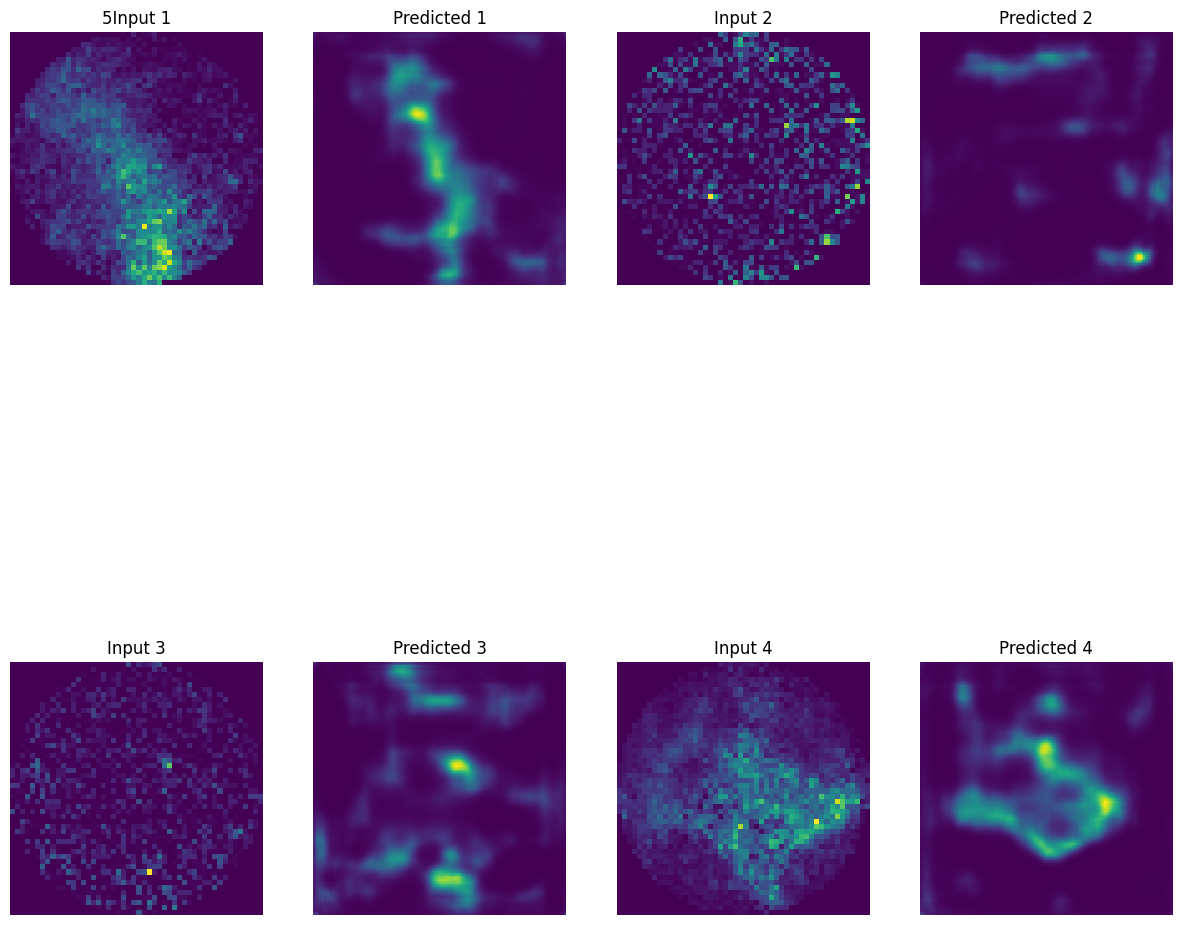

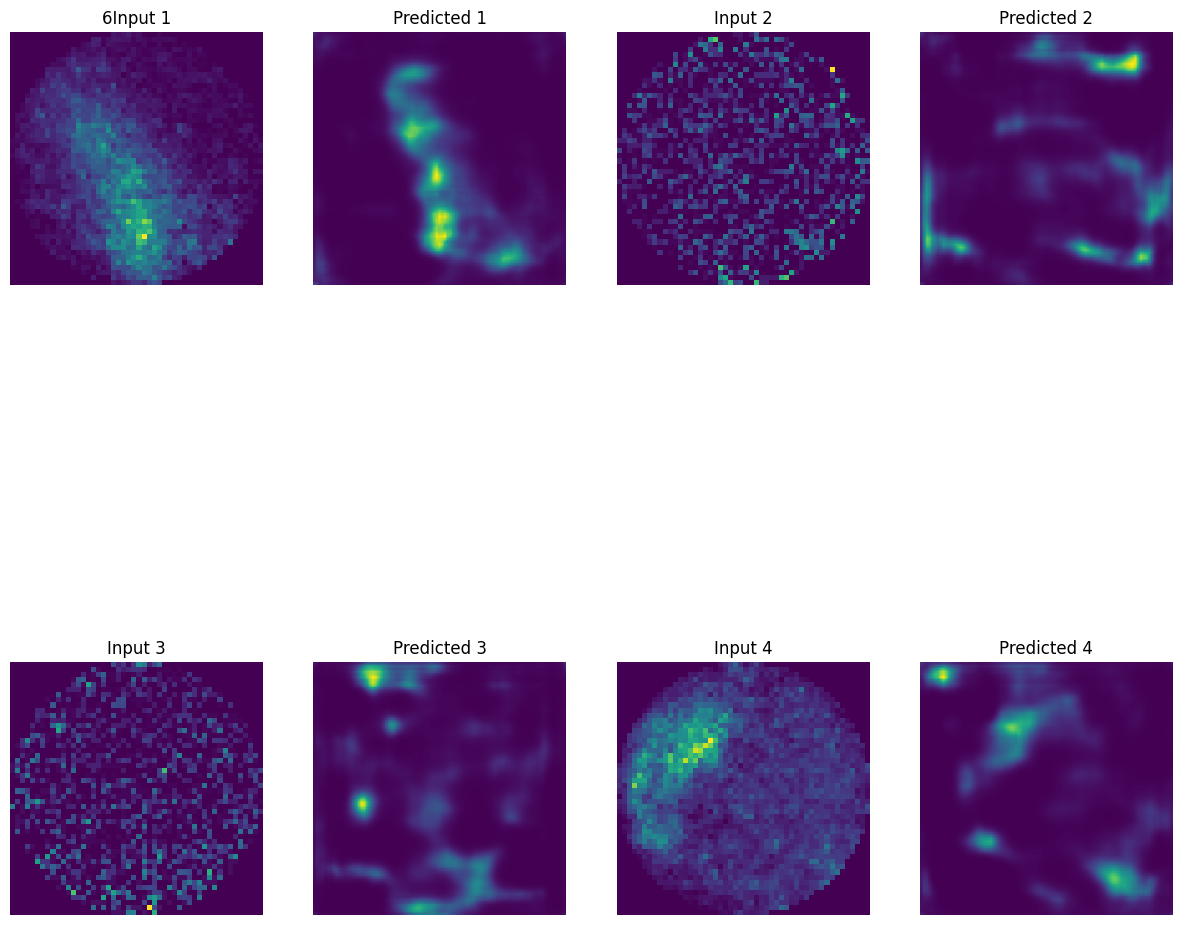

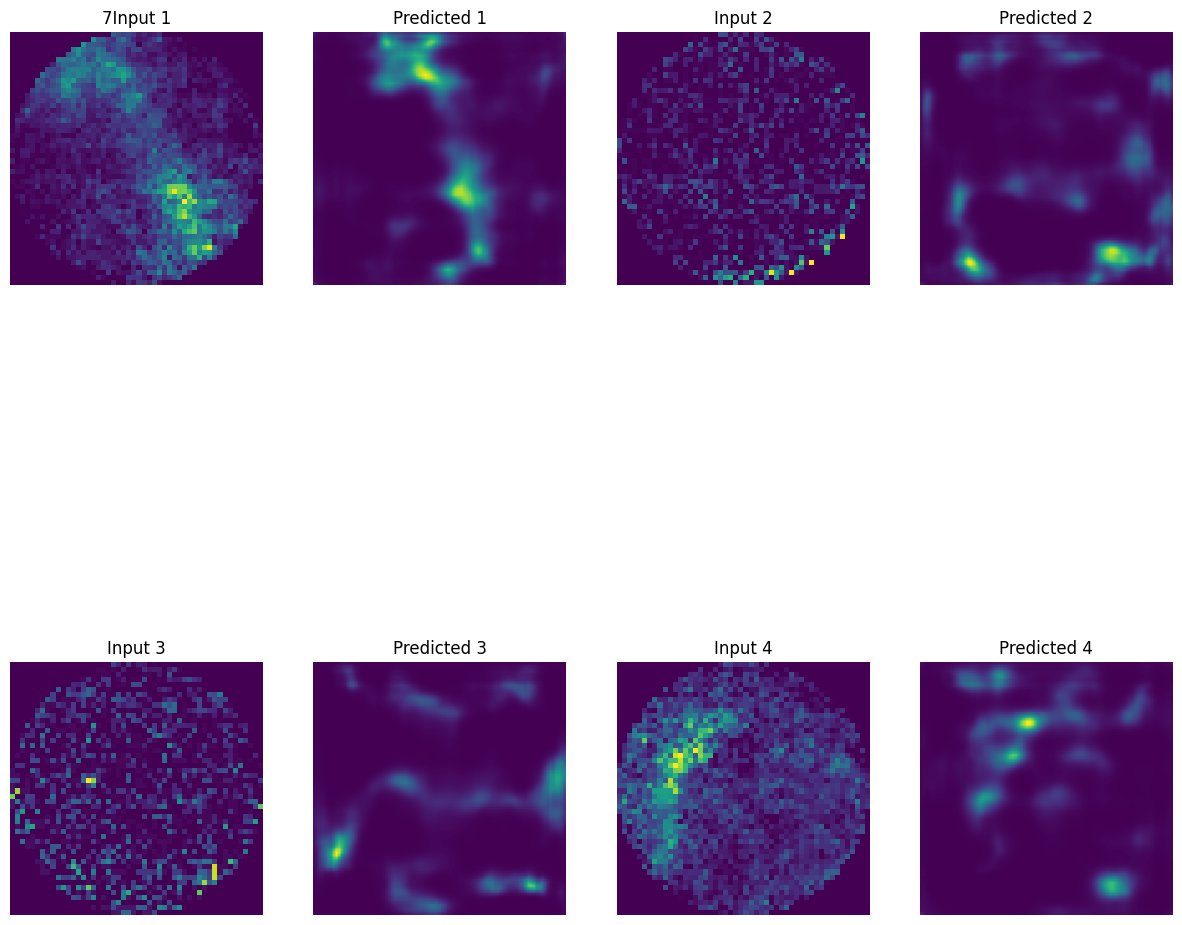

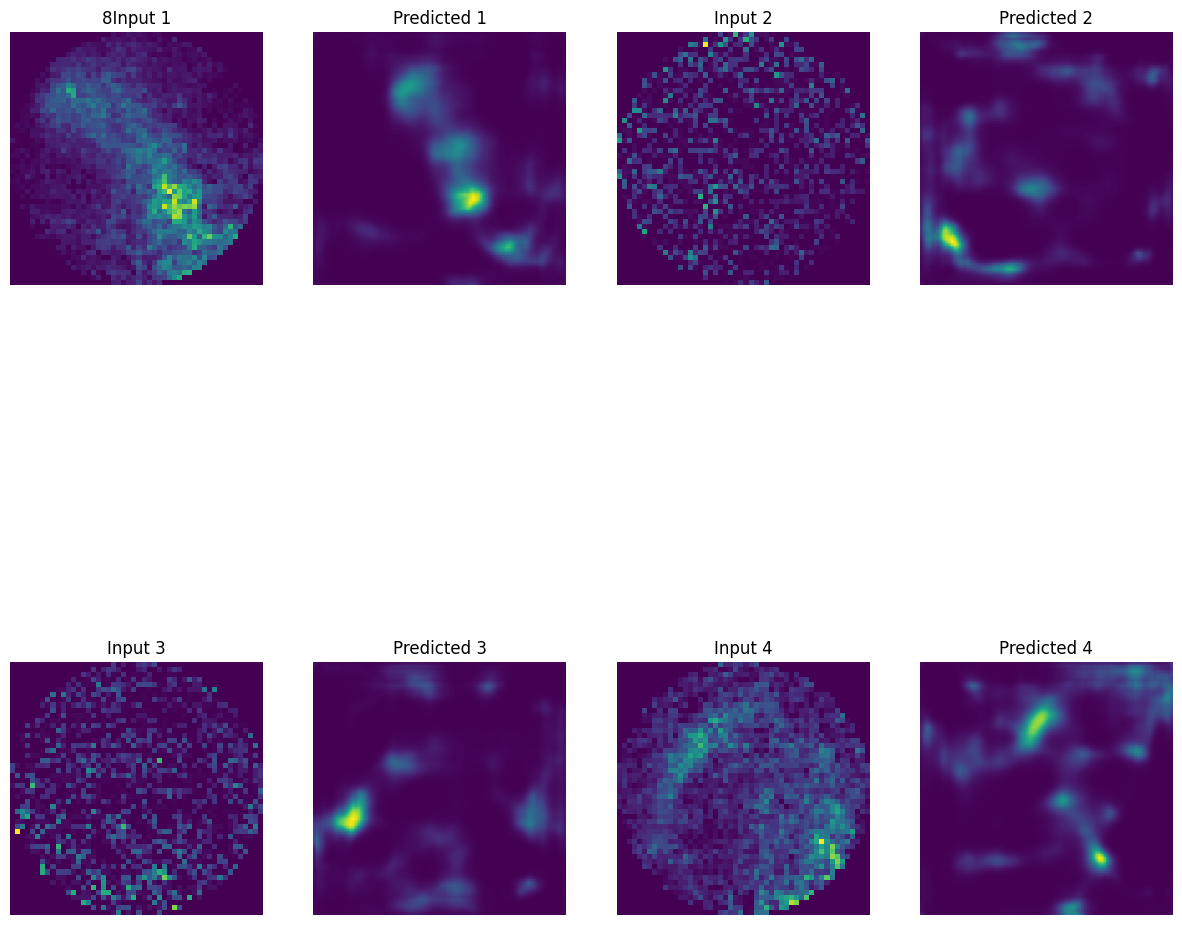

2024-09-26 21:33:20.461954: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Run the trained model on a few examples from the test set
for index, (sxr1, sxr2, sxr3, sxr4) in enumerate(input_dataset):
  generate_images(generator,index+1, sxr1, sxr2, sxr3, sxr4)